<h2> Capstone project: The Battle of Neighborhoods (week 2) </h2>
<h3> Business Prospect and Venues Data Analysis in Bali, Indonesia </h3> by: <b>Nur Cahyo Nugroho </b>

<img src="https://media.timeout.com/images/105240189/image.jpg" width="500" height="600">

<h3>1. Introduction</h3>
<p>Bali is one of main Indonesia's tourism destination, which has seen a significant rise in tourists since the 1980s. Tourism-related business makes up 80% of its economy. It is renowned for its highly developed arts, including traditional and modern dance, sculpture, painting, leather, metalworking, and music. There's so much business opportunity in this island, with potential customer from both local residents and the tourists. </p>
<p>Business owner will need to perform research and exploration of the neighborhood before open any business in specific location to understand many factors, like nearby residential area, tourist place & office, another similar competitor, public facilities, and most importantly average rental fare.</p>

<h3>2. Objective</h3>
<p>This project will give insight to restaurant business owner/investor to comparing neighborhoods based on districts in Bali to choose best suited location based on top 10 common venues surrounding it.</p>
<p>Methods:
<ul>
    <li>Web scraping the list of district and population in Bali from Wikipedia.</li>
    <li>Extracting top trending venues using Foursquare API. </li>
    <li>Forming neighborhood clusters based on venue categories using unsupervised <i>k-means</i> clustering algorithm. </li>
    <li>Understanding the similarities and differences between district to retrieve more insights and to conclude which neighborhood is best suited for business prospect. </li>
</ul></p>

<h3>3. Data Reference and Library</h3>
<h4>3.1. District list in Bali</h4>
I will be extracting list of districts and population in Bali from Wikipedia page: <a href="url">https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali</a>. 
Using read_html() to extract HTML table information from Wikipedia, and Panda libraries to load it into dataframe and perform necessary data clean-up. 
<h4>3.2. Geolocation of each district in Bali</h4>
Geolocation contains longtitude and latitude of each district in Bali from csv file that I upload in GitHub <a href="url">https://raw.githubusercontent.com/bluearticuno/Coursera_Capstone/master/Bali_Geospatial.csv</a>. Using panda dataframe to load the data and merge it with above district information, then get top venues using Foursquare API using geolocation information.
<h4>3.3. Library </h4>
<ul>
    <li>Panda libraries for dataframe and other dataset manipulation.</li>
    <li>Numpy for any scientific computation.</li>
    <li>Requests to call Foursquare API.</li>
    <li>KMeans cluster from sklearn for clustering.</li>
    <li>Matplotlib for plotting modules.</li>
    <li>Seaborn for bar graph plotting.</li>
    <li>Folium for map plotting.</li>
</ul>  

<h3>4. Python Notebook</h3>
<h4>4.1. Download and extract dataset</h4>

Import all necessary libraries:

In [193]:
import pandas as pd
import numpy as np
import requests

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
# we are using the inline backend
%matplotlib inline 

#seaborn for plotting
import seaborn as sns

#!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium=0.5.0 --yes

import folium # plotting library

from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported')

Libraries imported


Read data from Wikipedia and convert it to panda dataframe:

In [264]:
#Call from webpage url and store them as dataframes in an array, each element is a dataframe
wiki_tables = pd.read_html("https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali", header=0) 

#Convert to dataframe
bali_raw_df = wiki_tables[0]
bali_raw_df.head(10)
#Bali_raw_df.dtypes

#Create new dataframe, get 'Kabupaten/Kota' and 'Jumlah penduduk (2017)' as 'District' and 'Total Population'
bali_df = bali_raw_df[['Kabupaten/kota', 'Jumlah penduduk (2017)[1]']]
bali_df.rename(columns={'Kabupaten/kota':'District', 'Jumlah penduduk (2017)[1]':'District Population'}, inplace=True)
bali_df

,District,District Population
0,Kabupaten Badung,468.346
1,Kabupaten Bangli,264.945
2,Kabupaten Buleleng,814.356
3,Kabupaten Gianyar,492.757
4,Kabupaten Jembrana,323.211
5,Kabupaten Karangasem,545.389
6,Kabupaten Klungkung,215.852
7,Kabupaten Tabanan,466.647
8,Kota Denpasar,638.548


Convert float 'Population' into int:

In [266]:
i=0
for pop in bali_df['District Population']:
    bali_df.iloc[i,1] = int(str("{0:.3f}".format(round(pop,3))).replace('.', ''))
    i+=1

bali_df['District Population'] = bali_df['District Population'].astype(int)

C:\Users\nurca\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\nurca\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Dataframe after change datatype:

In [267]:
bali_df

,District,District Population
0,Kabupaten Badung,468346
1,Kabupaten Bangli,264945
2,Kabupaten Buleleng,814356
3,Kabupaten Gianyar,492757
4,Kabupaten Jembrana,323211
5,Kabupaten Karangasem,545389
6,Kabupaten Klungkung,215852
7,Kabupaten Tabanan,466647
8,Kota Denpasar,638548


Get geolocation for each distric of Bali from csv file:

In [275]:
#read csv data and put it in dataframe
geo_df = pd.read_csv('https://raw.githubusercontent.com/bluearticuno/Coursera_Capstone/master/Bali_Geospatial.csv')
geo_df.head(7)

,Kabupaten/Kota,Kecamatan,Latitude,Longitude
0,Kabupaten Badung,Abiansemal,-8.5584,115.2245
1,Kabupaten Badung,Kuta,-8.7238,115.1752
2,Kabupaten Badung,Kuta Selatan,-8.8063,115.1533
3,Kabupaten Badung,Kuta Utara,-8.6489,115.1593
4,Kabupaten Badung,Mengwi,-8.5617,115.1771
5,Kabupaten Badung,Petang,-8.3366,115.2245
6,Kabupaten Bangli,Bangli,-8.4330,115.3608


Merge both data:

In [276]:
merged_df = pd.merge(left=bali_df, right=geo_df, left_on='District', right_on='Kabupaten/Kota')
merged_df.drop(['Kabupaten/Kota'], axis=1, inplace=True)
merged_df.rename(columns={'Kecamatan':'Sub-District'}, inplace=True)
merged_df.head(7)

,District,District Population,Sub-District,Latitude,Longitude
0,Kabupaten Badung,468346,Abiansemal,-8.5584,115.2245
1,Kabupaten Badung,468346,Kuta,-8.7238,115.1752
2,Kabupaten Badung,468346,Kuta Selatan,-8.8063,115.1533
3,Kabupaten Badung,468346,Kuta Utara,-8.6489,115.1593
4,Kabupaten Badung,468346,Mengwi,-8.5617,115.1771
5,Kabupaten Badung,468346,Petang,-8.3366,115.2245
6,Kabupaten Bangli,264945,Bangli,-8.4330,115.3608


Create map of Bali:

In [277]:
# create map of Bali using latitude and longitude values
bali_map = folium.Map(location=[-8.34, 115.09], zoom_start=9)

# add markers to map
for lat, lng, district in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(bali_map)  
    
bali_map

Plot the data into barplot, and put different bar color for district that has total population more than 500,000 people as a focus:

Text(0.5, 1.0, 'Total population of each district in Bali')

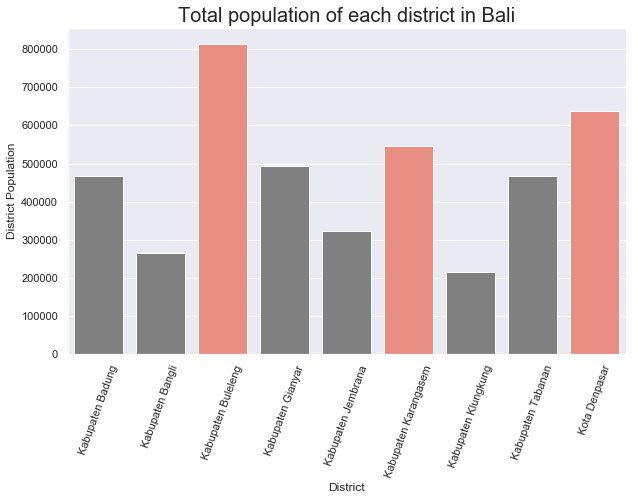

In [282]:
color = ['grey' if (x < 500000) else 'salmon' for x in bali_df['District Population']]

ax = sns.barplot(x="District", y="District Population", data=bali_df, palette=color)
sns.set(rc={'figure.figsize':(10,6)})
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
ax.set_title('Total population of each district in Bali', fontsize=20)


Based on above barplot, we will use 'Kabupaten Buleleng', 'Kabupaten Karangasem', 'Kota Denpasar':

In [287]:
dist = ['Kabupaten Buleleng', 'Kabupaten Karangasem', 'Kota Denpasar']
focused_df = merged_df[merged_df['District'].isin(dist)].reset_index(drop=True)
#merged_df.iloc[[2, 5, 8], :].reset_index(drop=True)
focused_df

,District,District Population,Sub-District,Latitude,Longitude
0,Kabupaten Buleleng,814356,Banjar,-8.2285,115.0347
1,Kabupaten Buleleng,814356,Buleleng,-8.2239,114.9517
2,Kabupaten Buleleng,814356,Busung Biu,-8.3262,114.9280
3,Kabupaten Buleleng,814356,Gerokgak,-8.2146,114.7855
4,Kabupaten Buleleng,814356,Kubutambahan,-8.1062,115.2126
5,Kabupaten Buleleng,814356,Sawan,-8.1587,115.1771
6,Kabupaten Buleleng,814356,Seririt,-8.2053,114.9280
7,Kabupaten Buleleng,814356,Sukasada,-8.1928,115.1178
8,Kabupaten Buleleng,814356,Tejakula,-8.1293,115.3193
9,Kabupaten Karangasem,545389,Abang,-8.3694,115.6273


Define Foursquare API credential:

In [288]:
CLIENT_ID = 'DBSEJZIAXAJDY0J3H32YWG231WYT54IEEDGLBYIE1SINFIEY' # your Foursquare ID
CLIENT_SECRET = '1UWUHAE3LATTQKRUPZ5RLXCHL1SH3KGUEDHCQPNQU0COYKZI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DBSEJZIAXAJDY0J3H32YWG231WYT54IEEDGLBYIE1SINFIEY
CLIENT_SECRET:1UWUHAE3LATTQKRUPZ5RLXCHL1SH3KGUEDHCQPNQU0COYKZI


Get neighborhood information, to get lang and lat:

In [289]:
neigh_lat = focused_df.loc[0, 'Latitude'] # neighborhood latitude value
neigh_long = focused_df.loc[0, 'Longitude'] # neighborhood longitude value

neighb_name = focused_df.loc[0, 'District'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighb_name, neigh_lat, neigh_long))

Latitude and longitude values of Kabupaten Buleleng are -8.2285, 115.0347.


Get top 100 venues with radius 10 kilometers from Kota Denpasar:

In [290]:
radius=10000
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neigh_lat, neigh_long, VERSION, radius, LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d36afac9df1dc00230fc338'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 69,
  'suggestedBounds': {'ne': {'lat': -8.13849990999991,
    'lng': 115.12546647568357},
   'sw': {'lat': -8.318500090000091, 'lng': 114.94393352431644}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bdf22dc7ea362b5205943c4',
       'name': 'Munduk Moding Plantation Resort Bali',
       'location': {'address': 'Br. Dinas Asa, Ds. Gobleg, Kec. Banjar, Buleleng',
        'lat': -8.240018623528147,
        'lng': 115.07071137250843,
        'label

Create get_category_type function:

In [291]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean json and put it in dataframe:

In [292]:
venues = results['response']['groups'][0]['items']

# flatten JSON
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Munduk Moding Plantation Resort Bali,Resort,-8.240019,115.070711
1,Munduk,Mountain,-8.263634,115.059512
2,Damai Lovina Villas Bali,Hotel Bar,-8.181425,115.043972
3,Puri Lumbung Cottages,Hotel,-8.264693,115.059353
4,Sanak Retreat Restaurant,Balinese Restaurant,-8.253628,115.029540


Info returned by Foursquare:

In [293]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

69 venues were returned by Foursquare.


<h4>4.2. Explore all venues on those 3 districts</h4>

Create function to find all venues

In [301]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Sub-District', 
                  'Sub-District Latitude', 
                  'Sub-District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Call above function and create new dataframe:

In [304]:
focused_venue = getNearbyVenues(names=focused_df['Sub-District'],
                                   latitudes=focused_df['Latitude'],
                                   longitudes=focused_df['Longitude']
                                  )

Banjar
Buleleng
Busung Biu
Gerokgak
Kubutambahan
Sawan
Seririt
Sukasada
Tejakula
Abang
Bebandem
Karangasem
Kubu
Manggis
Rendang
Selat
Sidemen
Denpasar Barat
Denpasar Selatan
Denpasar Timur
Denpasar Utara


In [305]:
focused_venue

,Sub-District,Sub-District Latitude,Sub-District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sawan,-8.1587,115.1771,Cafe cocacola beten bingin,-8.156245,115.178318,Bar
1,Seririt,-8.2053,114.9280,Santal,-8.201068,114.927315,Lake
2,Seririt,-8.2053,114.9280,Pantai Seririt,-8.200984,114.927610,Beach
3,Karangasem,-8.4297,115.6273,Jasri beach,-8.428145,115.630224,Beach
4,Denpasar Barat,-8.6666,115.1948,Starbucks Coffee,-8.664219,115.198003,Coffee Shop
5,Denpasar Barat,-8.6666,115.1948,Terang bulan dan martabak 'Sedap Mantap',-8.665786,115.198667,Food Truck
6,Denpasar Barat,-8.6666,115.1948,Coco Express,-8.664558,115.195004,Convenience Store
7,Denpasar Barat,-8.6666,115.1948,Indomaret,-8.664604,115.197508,Convenience Store
8,Denpasar Barat,-8.6666,115.1948,EKA Print Rinjani,-8.665185,115.198821,Print Shop
9,Denpasar Selatan,-8.6983,115.2482,Cupa-Cupa Corner (CCC),-8.697910,115.251220,Fast Food Restaurant


Get dataframe shape:

In [306]:
focused_venue.shape

(20, 7)

Check how many venues for each district:

In [308]:
focused_venue.groupby('Sub-District').count()

,Sub-District Latitude,Sub-District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Sub-District,,,,,,
Denpasar Barat,5,5,5,5,5,5
Denpasar Selatan,4,4,4,4,4,4
Denpasar Timur,4,4,4,4,4,4
Denpasar Utara,3,3,3,3,3,3
Karangasem,1,1,1,1,1,1
Sawan,1,1,1,1,1,1
Seririt,2,2,2,2,2,2


Find out unique venue category:

In [309]:
print('There are {} uniques categories.'.format(len(focused_venue['Venue Category'].unique())))

There are 16 uniques categories.


<h4>4.3. Analyze each sub-district</h4>

In [311]:
# one hot encoding
bali_onehot = pd.get_dummies(focused_venue[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bali_onehot['Sub-District'] = focused_venue['Sub-District'] 

# move neighborhood column to the first column
fixed_columns = [bali_onehot.columns[-1]] + list(bali_onehot.columns[:-1])
bali_onehot = bali_onehot[fixed_columns]

bali_onehot.head()

,Sub-District,American Restaurant,Asian Restaurant,Bakery,Balinese Restaurant,Bar,Beach,Bookstore,Coffee Shop,Convenience Store,Fast Food Restaurant,Food Truck,Indonesian Restaurant,Lake,Noodle House,Print Shop,Skate Park
0,Sawan,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Seririt,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Seririt,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Karangasem,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Denpasar Barat,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Check the new dataframe shape:

In [312]:
bali_onehot.shape

(20, 17)

Group rows by sub-district and by taking the mean of the frequency of occurrence of each category:

In [313]:
bali_grouped = bali_onehot.groupby('Sub-District').mean().reset_index()
bali_grouped.head()

,Sub-District,American Restaurant,Asian Restaurant,Bakery,Balinese Restaurant,Bar,Beach,Bookstore,Coffee Shop,Convenience Store,Fast Food Restaurant,Food Truck,Indonesian Restaurant,Lake,Noodle House,Print Shop,Skate Park
0,Denpasar Barat,0.000000,0.00,0.00,0.00,0.0,0.0,0.00,0.2,0.400000,0.00,0.2,0.00,0.0,0.000000,0.2,0.00
1,Denpasar Selatan,0.000000,0.25,0.00,0.00,0.0,0.0,0.00,0.0,0.000000,0.25,0.0,0.00,0.0,0.250000,0.0,0.25
2,Denpasar Timur,0.000000,0.00,0.25,0.25,0.0,0.0,0.25,0.0,0.000000,0.00,0.0,0.25,0.0,0.000000,0.0,0.00
3,Denpasar Utara,0.333333,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.333333,0.00,0.0,0.00,0.0,0.333333,0.0,0.00
4,Karangasem,0.000000,0.00,0.00,0.00,0.0,1.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.0,0.000000,0.0,0.00


Confirm new shape:

In [314]:
bali_grouped.shape

(7, 17)

Print each sub-district along with the top 5 most common venues:

In [316]:
num_top_venues = 5

for hood in bali_grouped['Sub-District']:
    print("----"+hood+"----")
    temp = bali_grouped[bali_grouped['Sub-District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Denpasar Barat----
                 venue  freq
0    Convenience Store   0.4
1          Coffee Shop   0.2
2           Food Truck   0.2
3           Print Shop   0.2
4  American Restaurant   0.0


----Denpasar Selatan----
                  venue  freq
0      Asian Restaurant  0.25
1  Fast Food Restaurant  0.25
2          Noodle House  0.25
3            Skate Park  0.25
4   American Restaurant  0.00


----Denpasar Timur----
                   venue  freq
0                 Bakery  0.25
1    Balinese Restaurant  0.25
2              Bookstore  0.25
3  Indonesian Restaurant  0.25
4    American Restaurant  0.00


----Denpasar Utara----
                 venue  freq
0  American Restaurant  0.33
1    Convenience Store  0.33
2         Noodle House  0.33
3     Asian Restaurant  0.00
4               Bakery  0.00


----Karangasem----
                 venue  freq
0                Beach   1.0
1  American Restaurant   0.0
2     Asian Restaurant   0.0
3               Bakery   0.0
4  Balinese Restaura

Create function to sort venue in descending order:

In [317]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create new dataframe and display top 5 of each sub-district:

In [332]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Sub-District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
subdist_venues_sorted = pd.DataFrame(columns=columns)
subdist_venues_sorted['Sub-District'] = bali_grouped['Sub-District']

for ind in np.arange(bali_grouped.shape[0]):
    subdist_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bali_grouped.iloc[ind, :], num_top_venues)

subdist_venues_sorted.head()

,Sub-District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Denpasar Barat,Convenience Store,Print Shop,Food Truck,Coffee Shop,Skate Park
1,Denpasar Selatan,Skate Park,Noodle House,Fast Food Restaurant,Asian Restaurant,Print Shop
2,Denpasar Timur,Indonesian Restaurant,Bookstore,Balinese Restaurant,Bakery,Skate Park
3,Denpasar Utara,Noodle House,Convenience Store,American Restaurant,Skate Park,Print Shop
4,Karangasem,Beach,Skate Park,Print Shop,Noodle House,Lake


<h4>4.4. Cluster the district </h4>

Run *k*-means to cluster the neighborhood into 3 clusters:

In [333]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

bali_grouped_clustering = bali_grouped.drop('Sub-District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bali_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5]

array([1, 1, 1, 1, 0])

Create a new dataframe that includes the cluster as well as the top 5 venues for each sub-district:

In [334]:
# add clustering labels
subdist_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bali_merged = focused_df

# merge bali_grouped with bali_data to add latitude/longitude for each neighborhood
bali_merged = bali_merged.join(subdist_venues_sorted.set_index('Sub-District'), on='Sub-District')


,District,District Population,Sub-District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Kabupaten Buleleng,814356,Banjar,-8.2285,115.0347,NaN,NaN,NaN,NaN,NaN,NaN
1,Kabupaten Buleleng,814356,Buleleng,-8.2239,114.9517,NaN,NaN,NaN,NaN,NaN,NaN
2,Kabupaten Buleleng,814356,Busung Biu,-8.3262,114.9280,NaN,NaN,NaN,NaN,NaN,NaN
3,Kabupaten Buleleng,814356,Gerokgak,-8.2146,114.7855,NaN,NaN,NaN,NaN,NaN,NaN
4,Kabupaten Buleleng,814356,Kubutambahan,-8.1062,115.2126,NaN,NaN,NaN,NaN,NaN,NaN


In [335]:
bali_merged.tail() # check the last columns!

,District,District Population,Sub-District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,Kabupaten Karangasem,545389,Sidemen,-8.4831,115.4378,NaN,NaN,NaN,NaN,NaN,NaN
17,Kota Denpasar,638548,Denpasar Barat,-8.6666,115.1948,1.0,Convenience Store,Print Shop,Food Truck,Coffee Shop,Skate Park
18,Kota Denpasar,638548,Denpasar Selatan,-8.6983,115.2482,1.0,Skate Park,Noodle House,Fast Food Restaurant,Asian Restaurant,Print Shop
19,Kota Denpasar,638548,Denpasar Timur,-8.6431,115.2423,1.0,Indonesian Restaurant,Bookstore,Balinese Restaurant,Bakery,Skate Park
20,Kota Denpasar,638548,Denpasar Utara,-8.6254,115.2067,1.0,Noodle House,Convenience Store,American Restaurant,Skate Park,Print Shop


Remove dataframe rows with NaN value:

In [346]:
bali_merged.dropna(inplace=True)
bali_merged.head()

,District,District Population,Sub-District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Kabupaten Buleleng,814356,Sawan,-8.1587,115.1771,2.0,Bar,Skate Park,Print Shop,Noodle House,Lake
6,Kabupaten Buleleng,814356,Seririt,-8.2053,114.9280,0.0,Lake,Beach,Skate Park,Print Shop,Noodle House
11,Kabupaten Karangasem,545389,Karangasem,-8.4297,115.6273,0.0,Beach,Skate Park,Print Shop,Noodle House,Lake
17,Kota Denpasar,638548,Denpasar Barat,-8.6666,115.1948,1.0,Convenience Store,Print Shop,Food Truck,Coffee Shop,Skate Park
18,Kota Denpasar,638548,Denpasar Selatan,-8.6983,115.2482,1.0,Skate Park,Noodle House,Fast Food Restaurant,Asian Restaurant,Print Shop


Visualize the resulting clusters:

In [347]:
# create map
map_clusters = folium.Map(location=[-8.34, 115.09], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bali_merged['Latitude'], bali_merged['Longitude'], bali_merged['Sub-District'], bali_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<b>Examining cluster</b>

Cluster 1:

In [348]:
bali_merged.loc[bali_merged['Cluster Labels'] == 0, bali_merged.columns[[2] + list(range(5, bali_merged.shape[1]))]]

,Sub-District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Seririt,0.0,Lake,Beach,Skate Park,Print Shop,Noodle House
11,Karangasem,0.0,Beach,Skate Park,Print Shop,Noodle House,Lake


Cluster 2:

In [344]:
bali_merged.loc[bali_merged['Cluster Labels'] == 1, bali_merged.columns[[2] + list(range(5, bali_merged.shape[1]))]]

,Sub-District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,Denpasar Barat,1.0,Convenience Store,Print Shop,Food Truck,Coffee Shop,Skate Park
18,Denpasar Selatan,1.0,Skate Park,Noodle House,Fast Food Restaurant,Asian Restaurant,Print Shop
19,Denpasar Timur,1.0,Indonesian Restaurant,Bookstore,Balinese Restaurant,Bakery,Skate Park
20,Denpasar Utara,1.0,Noodle House,Convenience Store,American Restaurant,Skate Park,Print Shop


Cluster 3:

In [345]:
bali_merged.loc[bali_merged['Cluster Labels'] == 2, bali_merged.columns[[2] + list(range(5, bali_merged.shape[1]))]]

,Sub-District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Sawan,2.0,Bar,Skate Park,Print Shop,Noodle House,Lake


Let's compare sub-district within Bali and choose the best location:

In [349]:
compare_df = bali_merged.set_index("Sub-District",drop=True)
compare_df.head()

,District,District Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Sub-District,,,,,,,,,,
Sawan,Kabupaten Buleleng,814356,-8.1587,115.1771,2.0,Bar,Skate Park,Print Shop,Noodle House,Lake
Seririt,Kabupaten Buleleng,814356,-8.2053,114.9280,0.0,Lake,Beach,Skate Park,Print Shop,Noodle House
Karangasem,Kabupaten Karangasem,545389,-8.4297,115.6273,0.0,Beach,Skate Park,Print Shop,Noodle House,Lake
Denpasar Barat,Kota Denpasar,638548,-8.6666,115.1948,1.0,Convenience Store,Print Shop,Food Truck,Coffee Shop,Skate Park
Denpasar Selatan,Kota Denpasar,638548,-8.6983,115.2482,1.0,Skate Park,Noodle House,Fast Food Restaurant,Asian Restaurant,Print Shop


In the above finding, we have noticed 'Denpasar Timur', 'Denpasar Barat', and 'Sawan' are among the sub-district having restaurants and bars. Let's compare this neighborhood:

In [350]:
subdist_comparison=compare_df.loc[['Denpasar Timur', 'Denpasar Barat', 'Sawan']].T
subdist_comparison

Sub-District,Denpasar Timur,Denpasar Barat,Sawan
District,Kota Denpasar,Kota Denpasar,Kabupaten Buleleng
District Population,638548,638548,814356
Latitude,-8.6431,-8.6666,-8.1587
Longitude,115.242,115.195,115.177
Cluster Labels,1,1,2
1st Most Common Venue,Indonesian Restaurant,Convenience Store,Bar
2nd Most Common Venue,Bookstore,Print Shop,Skate Park
3rd Most Common Venue,Balinese Restaurant,Food Truck,Print Shop
4th Most Common Venue,Bakery,Coffee Shop,Noodle House
5th Most Common Venue,Skate Park,Skate Park,Lake


<h3>5. Discussion </h3>

As per mentioned in introduction part, Bali has bigger market due to its main attraction for tourists. There's so much business opportunity in this island, with potential customer from both local residents and the tourists. Total population densities in the 9 districts (called as Kabupaten/Kota) can be considered as well as the potential market target. Each of district can have various sub-districts (called as Kecamatan), and each has different venues categories.

I got the district list information from Wikipedia, and sub-district geo location from csv files. After merge both data together into dataframe. After plot into barplot and visualize in different color for population that has more than 500,000 people, then I used Foursquare API to get list of available venues based on focused districts.

One of challenge that I experience with Foursquare API, not many venues is available despite I put radius as 10km. 

I ended the study by visualizing the data and clustering information on the Bali map. In future studies, rental detail per sub-district can be added to provide more insight on business owner if want to consider to open business in a location.

<h3>6. Conclusion </h3>

As a result of clustering and comparison, people will have more insight if they want to open business in specific location. With this information, business owner can achieve better decision through their access availability to the reports/platforms where such information is provided.

Not only for business owner/investor, it will be usefull for local government as well to understand about the business diversity and prospect in their local area.